In [111]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import stockutils


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import export_graphviz
from graphviz import Source

from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten
from keras.optimizers import Nadam, Adam

from torch.utils.tensorboard import SummaryWriter

#track experiments
import wandb
from wandb.integration.xgboost import WandbCallback

# Where to save the figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "exploratory_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

#targetName = "TwoStDayAfterMajRev"
targetName = "TwoStateMajorReversals"

In [112]:
stockdf, targetdf, otherdf = stockutils.import_stock_csv("AAPL_Advanced.csv", target=targetName)
y_orig = targetdf["Target"]
print(y_orig.shape)

(2371,)


In [57]:
#y_cat = pd.Categorical(targetdf['Target']).codes

In [58]:
stockdf.shape

(2371, 23)

In [113]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Example data
#data = pd.read_csv('../data/raw/AAPL_Advanced.csv')  # Load your data
#prices = data['close'].values  # Assuming your data has a 'price' column

sequence_length = 10  # Length of input sequences
prediction_horizon = 10  # Predict 10 days ahead

#NOTE I cannot get this to work unless the sequence length == prediction_horizon

def create_sequences(X_data, y_data, seq_length, pred_horizon):
    xs, ys = [], []
    # we will chop off seq_length + pred_horizon samples from the end of our y data
    for i in range(len(X_data) - seq_length - pred_horizon):
        #This slice represents one input sequence for the LSTM model. copying seq_length future steps to each x, (so we get a list at each x index)
        x = X_data[i:(i + seq_length)]
        # for y, we copy the  'pred_horizon' targets to each y, offset from x by seq_length (these are the actual BUY or SELL signals), and extends to the prediction horizon
        y = y_data[(i + seq_length):(i + seq_length + pred_horizon)] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


# Create sequences and labels
#X, y = create_sequences(stockdf.values, y_cat, sequence_length, prediction_horizon)
X, y = create_sequences(stockdf.values, targetdf.values, sequence_length, prediction_horizon)







In [114]:
X.shape, y.shape

((2351, 10, 23), (2351, 10, 1))

In [95]:
# Reshape X to fit LSTM input shape [samples, time steps, features]  - Its really already there
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

In [96]:
X.shape

(2351, 10, 23)

In [97]:
y.shape

(2351, 10, 1)

We need y in numeric terms, one-hot encode them

In [98]:
# Reshape y to match the expected output shape [samples, time steps, classes]
y_flat = y.flatten()
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_flat)
y_categorical = to_categorical(y_encoded)

# Reshape y back to match the model output shape
y_cat = y_categorical.reshape(y.shape[0], y.shape[1], -1)

In [99]:
y_cat

array([[[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       ...,

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]], dtype=float32)

In [100]:
y_cat.shape

(2351, 10, 2)

In [101]:
# now each y is a sequence of length 10
len(y_cat[232])


10

In [115]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed

num_features = 23  
num_classes = 2  # Binary classification: BUY or SELL

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, num_features), return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [116]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Convert labels to categorical (one-hot encoding)
#y = to_categorical(y, num_classes=num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, shuffle=False)

In [117]:


# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/20
59/59 [==============================] - 10s 114ms/step - loss: 0.7470 - accuracy: 0.6618 - val_loss: 0.8020 - val_accuracy: 0.5454
Epoch 2/20
59/59 [==============================] - 6s 99ms/step - loss: 0.6120 - accuracy: 0.6936 - val_loss: 0.7422 - val_accuracy: 0.5119
Epoch 3/20
59/59 [==============================] - 6s 95ms/step - loss: 0.6010 - accuracy: 0.6962 - val_loss: 0.7312 - val_accuracy: 0.4730
Epoch 4/20
59/59 [==============================] - 5s 92ms/step - loss: 0.5959 - accuracy: 0.6969 - val_loss: 0.7304 - val_accuracy: 0.5342
Epoch 5/20
59/59 [==============================] - 5s 93ms/step - loss: 0.5866 - accuracy: 0.7003 - val_loss: 0.7294 - val_accuracy: 0.4955
Epoch 6/20
59/59 [==============================] - 5s 91ms/step - loss: 0.5852 - accuracy: 0.7032 - val_loss: 0.8358 - val_accuracy: 0.5234
Epoch 7/20
59/59 [==============================] - 5s 92ms/step - loss: 0.5741 - accuracy: 0.6990 - val_loss: 0.7586 - val_accuracy: 0.4620
Epoch 8/20


In [105]:
import numpy as np

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions from one-hot encoded format to label indices
y_pred_labels = np.argmax(y_pred, axis=-1)


15/15 [==============================] - 1s 25ms/step


In [106]:
# Decode predictions back to original labels
y_pred_decoded = label_encoder.inverse_transform(y_pred_labels.flatten())

# Reshape to match the original shape of the test labels
y_pred_decoded = y_pred_decoded.reshape(y_pred_labels.shape)


In [107]:
y_pred_decoded

array([['BUY', 'BUY', 'BUY', ..., 'BUY', 'BUY', 'SELL'],
       ['BUY', 'BUY', 'BUY', ..., 'BUY', 'BUY', 'SELL'],
       ['BUY', 'BUY', 'BUY', ..., 'BUY', 'BUY', 'SELL'],
       ...,
       ['BUY', 'BUY', 'SELL', ..., 'SELL', 'BUY', 'BUY'],
       ['BUY', 'BUY', 'SELL', ..., 'SELL', 'BUY', 'BUY'],
       ['BUY', 'BUY', 'SELL', ..., 'SELL', 'BUY', 'SELL']], dtype=object)

In [108]:
import pandas as pd

# Split the dates to match the test set
dates = otherdf.index[-len(y_pred_labels):]

# Create a DataFrame with dates and predictions
predictions_df = pd.DataFrame(data=y_pred_decoded, index=dates)

# Flatten the DataFrame to have one signal per date
predictions_df = predictions_df.apply(lambda x: x[0], axis=1)


In [118]:
dates

Index(['8/1/2022', '8/2/2022', '8/3/2022', '8/4/2022', '8/5/2022', '8/8/2022',
       '8/9/2022', '8/10/2022', '8/11/2022', '8/12/2022',
       ...
       '5/31/2024', '6/3/2024', '6/4/2024', '6/5/2024', '6/6/2024', '6/7/2024',
       '6/10/2024', '6/11/2024', '6/12/2024', '6/13/2024'],
      dtype='object', name='date', length=471)

In [109]:
predictions_df.head()

date
8/1/2022    BUY
8/2/2022    BUY
8/3/2022    BUY
8/4/2022    BUY
8/5/2022    BUY
dtype: object

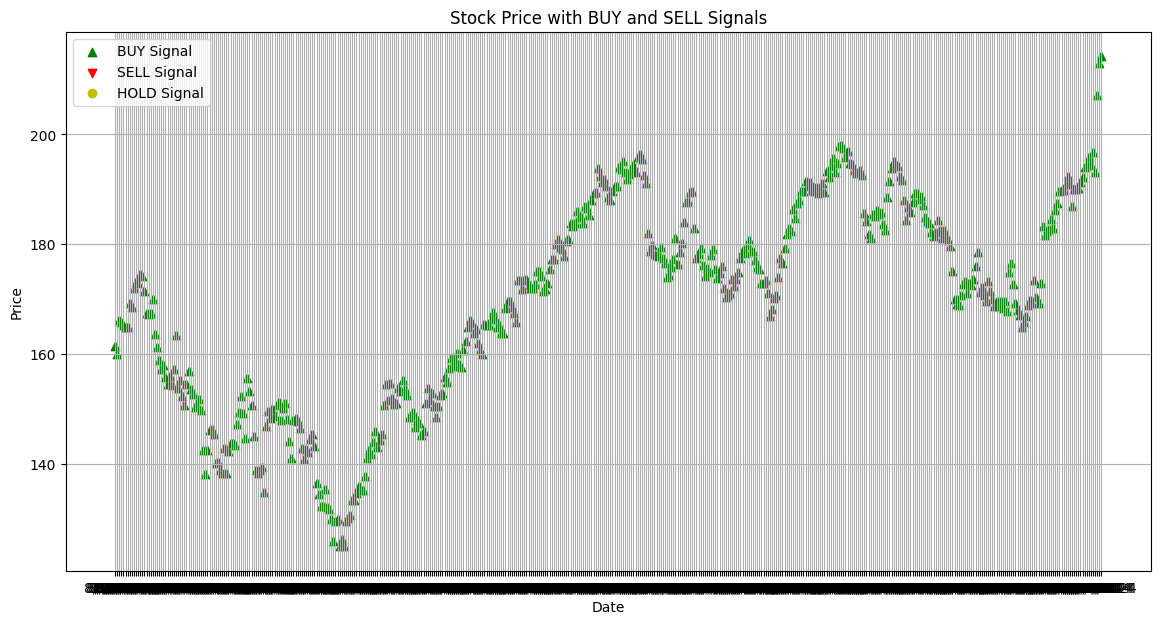

In [110]:
import matplotlib.pyplot as plt

# Plot the prices
plt.figure(figsize=(14, 7))
#plt.plot(otherdf.index, otherdf['close'], label='Price')

# Plot BUY signals
buy_signals = predictions_df[predictions_df == 'BUY'].index
plt.scatter(buy_signals, otherdf.loc[buy_signals, 'close'], marker='^', color='g', label='BUY Signal', alpha=1)

# Plot SELL signals
sell_signals = predictions_df[predictions_df == 'SELL'].index
plt.scatter(sell_signals, otherdf.loc[sell_signals, 'close'], marker='v', color='r', label='SELL Signal', alpha=1)

# Optionally, plot HOLD signals (if needed)
hold_signals = predictions_df[predictions_df == 'HOLD'].index
plt.scatter(hold_signals, otherdf.loc[hold_signals, 'close'], marker='o', color='y', label='HOLD Signal', alpha=1)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price with BUY and SELL Signals')
plt.legend()
plt.grid()
plt.show()


In [79]:
buy_signals

Index(['8/1/2022', '8/2/2022', '8/3/2022', '8/4/2022', '8/5/2022', '8/8/2022',
       '8/9/2022', '8/10/2022', '8/11/2022', '8/12/2022',
       ...
       '4/10/2024', '4/11/2024', '6/4/2024', '6/5/2024', '6/6/2024',
       '6/7/2024', '6/10/2024', '6/11/2024', '6/12/2024', '6/13/2024'],
      dtype='object', name='date', length=193)